In [48]:
import pytesseract
import cv2
from PIL import Image
import numpy as np
from sklearn.cluster import DBSCAN
from skimage.filters import threshold_local
import matplotlib.pyplot as plt

In [49]:
def get_RF_bboxes(image_path, contrast_window_size=5, contrast_tresh_value=40, dbscan_eps=60, dbscan_min_samples=50):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Impossible de charger l'image: {image_path}")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # --- PARTIE 1: DÉTECTION DES ZONES ULTRA-CONTRASTÉES ---

    local_thresh = threshold_local(gray, contrast_window_size, offset=0, method='gaussian')
    contrast = np.abs(gray.astype(np.float32) - local_thresh)

    # --- PARTIE 2: FILTRAGE DES ZONES À CONTRASTE ÉLEVÉ ---

    contrast_thresh = np.zeros_like(contrast, dtype=np.uint8)
    contrast_thresh[contrast > contrast_tresh_value] = 255

    # --- PARTIE 3: EXTRACTION DES BOUNDING BOXES VIA CLUSTERING ---

    points = np.column_stack(np.where(contrast_thresh > 0))
    db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(points)  #50,20
    labels = db.labels_
    unique_labels = set(labels)
    unique_labels.discard(-1)

    bboxes = []
    for label in unique_labels:
        cluster_points = points[labels == label]
        x_min = np.min(cluster_points[:, 1])
        y_min = np.min(cluster_points[:, 0])
        x_max = np.max(cluster_points[:, 1])
        y_max = np.max(cluster_points[:, 0])
        bbox = [[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]]
        bboxes.append(bbox)

    return bboxes

In [ ]:
def preprocess_image(img, contrast_window_size=5, contrast_tresh_value=40):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    local_thresh = threshold_local(gray, contrast_window_size, offset=0, method='gaussian')
    contrast = np.abs(gray.astype(np.float32) - local_thresh)

    contrast_thresh = np.zeros_like(contrast, dtype=np.uint8)
    contrast_thresh[contrast > contrast_tresh_value] = 255
    return contrast_thresh

def rotate_image(mat, angle_deg):
        (h, w) = mat.shape[:2]
        center = (w / 2, h / 2)
        M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))
        M[0, 2] += (nW / 2) - center[0]
        M[1, 2] += (nH / 2) - center[1]
        rotated = cv2.warpAffine(mat, M, (nW, nH),
                                flags=cv2.INTER_CUBIC,
                                borderMode=cv2.BORDER_CONSTANT,
                                borderValue=(255, 255, 255))
        return rotated

def deskew_minAreaRect(gray_img, angle_threshold=2):
    _, bin_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    coords = np.column_stack(np.where(bin_img > 0))
    if len(coords) == 0:
        return gray_img, 0
    rect = cv2.minAreaRect(coords)
    (cx, cy), (w, h), angle = rect
    if w < h:
        angle += 90
    if abs(angle) < angle_threshold:
        angle = 0
    angle -= 90
    rotated = rotate_image(gray_img, -angle)
    return rotated

def get_texts(bboxes, image_path):
    image = Image.open(image_path)
    image = preprocess_image(image) #########################################################################
    texts = []
    modified_imgs = [] ######################################################################################
    for bbox in bboxes :
        (x0, y0), (x1, y1) = bbox[0], bbox[2]
        cropped_img = image.crop((x0-10, y0-10, x1+10, y1+10)) #Crops élargis

        cv2_image = np.array(cropped_img)
        if len(cv2_image.shape) == 3 and cv2_image.shape[2] == 4:
            cv2_image = cv2_image[:, :, :3]
        gray = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2GRAY)

        # --- Réduction du bruit ---
        denoised = cv2.medianBlur(gray, 3)
        kernel_small = cv2.getStructuringElement(cv2.MORPH_OPEN, (2, 2))
        denoised = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel_small, iterations=1)
        oriented = deskew_minAreaRect(denoised)

        #no_lines = remove_lines_by_contours(oriented)

        # --- Reconnaissance de texte (OCR) avec Tesseract ---
        config = (
        "--oem 1 "  # utilise le moteur LSTM
        "--psm 10 "  # traite l'image comme une seule ligne de texte
        "-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        )
        recognized_text = pytesseract.image_to_string(oriented, config=config)
        texts.append(recognized_text.strip())
        modified_imgs.append(oriented) ########################################################################
    return texts, modified_imgs ###############################################################################

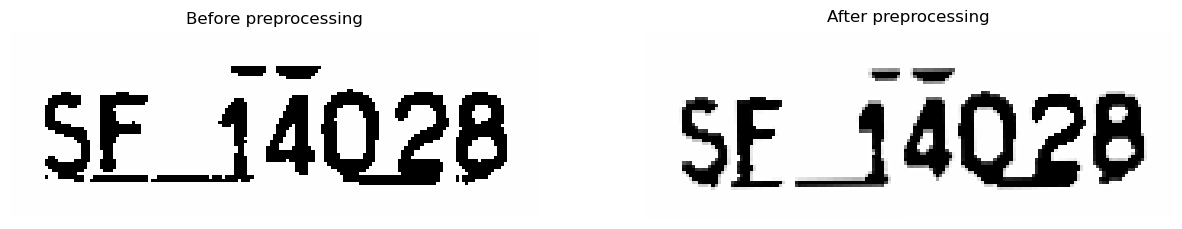

SF14028


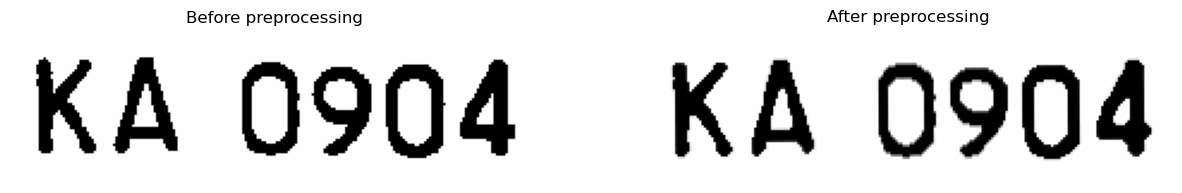

KA0904


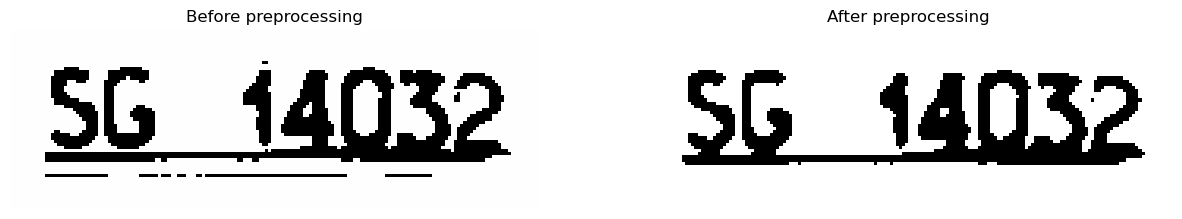

3644052


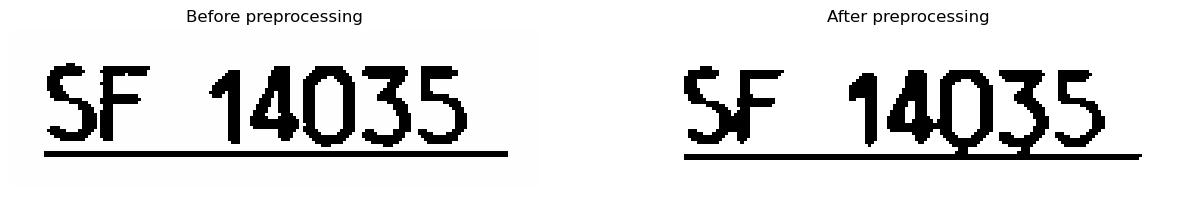

SF14035


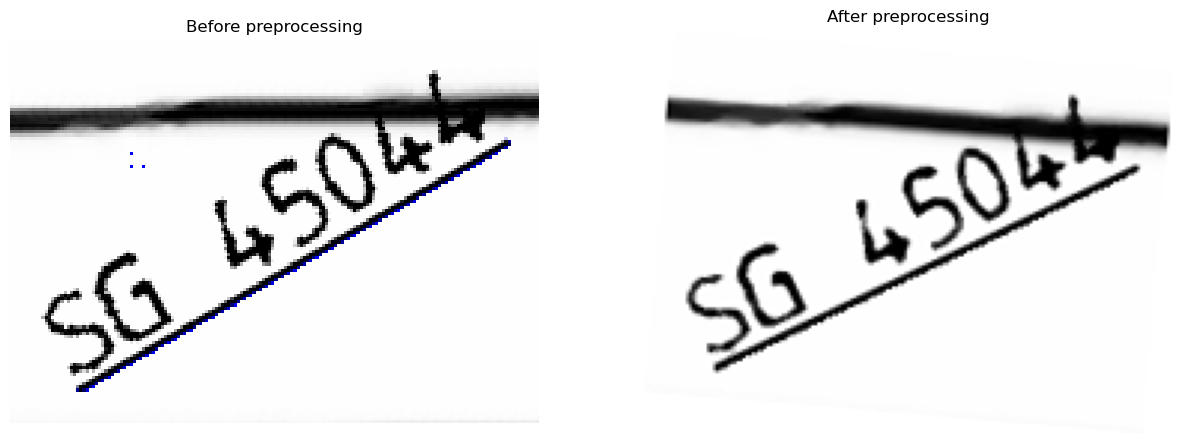

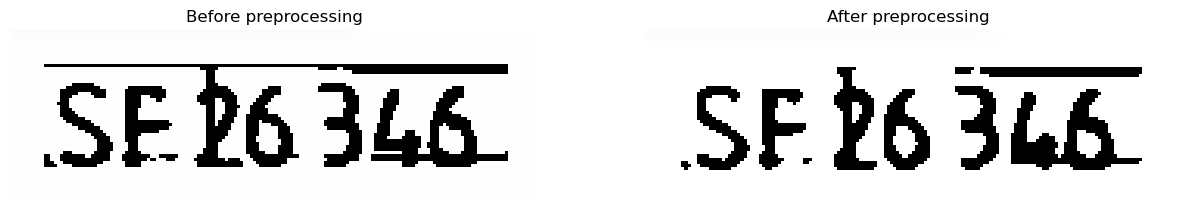

SE26346


In [51]:
id = '92094746'
image_path = f'data/train/images/{id}.png'
image = Image.open(image_path)

boxes = get_RF_bboxes(image_path)
texts, modified_imgs = get_texts(boxes, image_path)

for i, box in enumerate(boxes):
    (x_min, y_min), (x_max, y_max) = box[0], box[2]
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(image.crop((x_min-10, y_min-10, x_max+10, y_max+10)))
    axs[0].set_title('Before preprocessing')
    axs[0].axis('off')
    axs[1].imshow(modified_imgs[i], cmap='gray')
    axs[1].set_title('After preprocessing')
    axs[1].axis('off')
    plt.show()
    print(texts[i])